# Json file analysis
This json dump contains multi level nested structure, though not complex, let find out distinct nested keys and their parent

In [4]:
# this is because jupyter kernel dies very often, so on restarts, all the imports need to be reloaded
# ipythonkernel is notories for not loading relative path to current folder, 
# but rather staying in /conda/bin folder, the 'module_path' variable below takes care of it

import json, sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as u
print(os.getcwd())

c:\Projects\boxed-assignment-demo-1\Requirement


### Converting the file to valid JSON
The file is collection of json dictionaries, but not embedded in a json root node, lets do that, not sure if we need it but just in case

In [5]:
json_events = {}
with open('testEventData-1.txt', 'r') as f:
    events = [json.loads(line) for line in f]
json_events['events'] = events
with open('testEventData-1.json', 'w', encoding='utf-8') as f:
    json.dump(json_events, f, ensure_ascii=False, indent=4)


### Tree view
Lets see how this JSON tree looks like

[('properties', 'report'), ('properties', 'performance'), ('properties', 'bsProperties'), ('properties', 'filterMethod'), ('properties', 'smartbrand'), ('address', 'telephoneVerification'), ('event', 'properties'), ('properties', 'thestralFeatures'), ('properties', 'address'), ('properties', 'queryParameters')]
strict digraph tree {
    properties -> report;
    properties -> performance;
    properties -> bsProperties;
    properties -> filterMethod;
    properties -> smartbrand;
    address -> telephoneVerification;
    event -> properties;
    properties -> thestralFeatures;
    properties -> address;
    properties -> queryParameters;
}


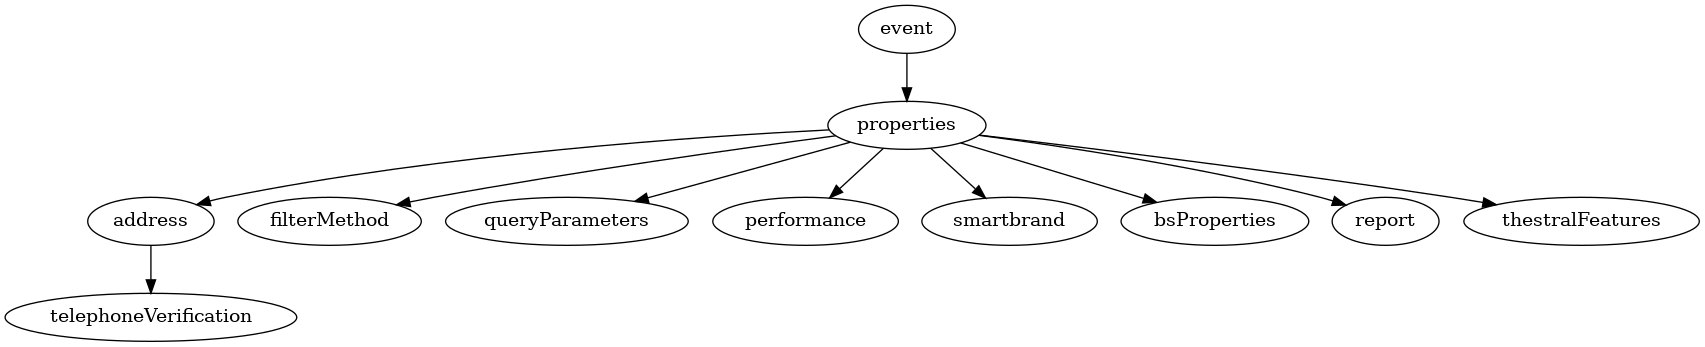

In [6]:
import json, os, graphviz
from graphviz import Source
import graphviz
from IPython.display import Image

# variables
edges = []

for item in json_events['events']:
    u.distinct_depth_nodes(item, 'event')
edges_deduped = u.removeDuplicates(u.edges)
print(edges_deduped)

# Dump edges in a grapgViz format
g = graphviz.Digraph('G', filename='json_tree.gv', format='png')
digraphStr = 'strict digraph tree {\n'
for row in edges_deduped:
    digraphStr = digraphStr + '    {0} -> {1};\n'.format(*row)
    g.edge(*row)
digraphStr = digraphStr + '}'
print(digraphStr)
graph_img_filePath = os.path.join(os.getcwd(), 'json_tree.gv')
g.save()
# lets open Digraph image
Image(filename=graph_img_filePath + '.png')

### Repeat column names
Lets check if there are any repeat column names inside the nested structure, because this will hinder us from creating a flat 1NF de-normalized single table for output  
e.g. say a column **user** is at root "event" level, but also inside **properties.user** or more levels down in future. Trying to flatten the table will stop us from creating two **user** columns

In [7]:
import json, utils as u
import pandas as pd

TABLE_SCHEMA_DICT = {}

with open('testEventData-1.txt', 'r') as f:
    events = [json.loads(line) for line in f]
events_denormalized_df = pd.json_normalize(events, max_level=3)
sorted_col_list = events_denormalized_df.columns.tolist()
sorted_col_list.sort()
col_list = u.distinct_col_list(sorted_col_list)
col_list.sort()

# are there any repeated elements here?
print("Are columns repeated? : " + str(any(col_list.count(x) > 1 for x in col_list)))
# lets check columns are repeated
is_col_repeated = dict(zip(col_list, [col_list.count(x) > 1 for x in col_list]))
repeated_col_list = {k:v for k,v in is_col_repeated.items() if v == True}
print("Following columns are repeated : ")
print([key for key in repeated_col_list.keys()])

Are columns repeated? : True
Following columns are repeated : 
['os', 'postalCode']


### The delima
One way of solving this is to identify the column with its nested parent structure, such as keeping it as **properties.user**

In [8]:
# lets check at which nested levels are these repeated
col_nodes = list(filter(lambda x:x.endswith(tuple(repeated_col_list.keys())), sorted_col_list))
print("These columns are embedded in following nested structures")
print(col_nodes)

These columns are embedded in following nested structures
['properties.address.postalCode', 'properties.bsProperties.postalCode', 'properties.os', 'properties.postalCode', 'properties.userAgent.os']


But this might get too long and stop certain databases for column name max character restrictions  
for e.g. names like **properties.thestralFeatures.excludeRedeemedCouponsFromClientResponse**

In [9]:
col_name = "properties.thestralFeatures.excludeRedeemedCouponsFromClientResponse"
print(f"The length of column \"{col_name}\" is : " + str(len(col_name)))

The length of column "properties.thestralFeatures.excludeRedeemedCouponsFromClientResponse" is : 68


The above col limit might be allowed in big databases like **Snowflake** but blocked in regular RDBMS's like **postgreSQL** or **mysql**, and even with **Snowflake's** awesome 251 character limit, we might have nested structure that starts testing that!

### Final Solution (JSON -> SQL)
For the challenges explained and demonstrated above, even though modern **columnar** databases like [Snowflake](https://www.snowflake.com/en/) or [Redshift](https://aws.amazon.com/pm/redshift/) supports 100s of 1000s of columns across, its safer to create seperate table at each nested level, each nested key table having 'fk' reference to original root table 'events' **eventId** so it becomes 2NF form